# Person Re-identification using a Siamese Network

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

##Download Full Dataset

Market-1501 dataset : https://www.kaggle.com/pengcw1/market-1501

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

## Configurations

In [ ]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[11]

A_img = io.imread(fname = DATA_DIR + row.Anchor)
P_img = io.imread(fname = DATA_DIR + row.Positive)
N_img = io.imread(fname = DATA_DIR + row.Negative)

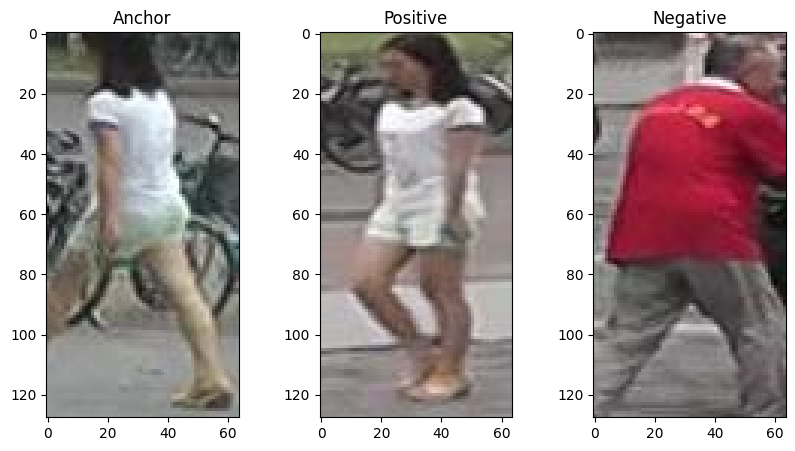

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

##Create APN Database

In [ ]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return(len(self.df))

  def __getitem__(self, idx):
    row = df.iloc[idx]

    A_img = io.imread(fname = DATA_DIR + row.Anchor)
    P_img = io.imread(fname = DATA_DIR + row.Positive)
    N_img = io.imread(fname = DATA_DIR + row.Negative)

    # Converting from numpy to tensor, changing the format from (H, W, C) to (C, H, W)
    A_img = torch.from_numpy(A_img).permute(2, 0, 1)
    P_img = torch.from_numpy(P_img).permute(2, 0, 1)
    N_img = torch.from_numpy(N_img).permute(2, 0, 1)

    return(A_img, P_img, N_img)

In [ ]:
# Creating Dataset from train and valid dataframes
trainset = APN_Dataset(train_df)
testset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 3200
Size of testset : 800


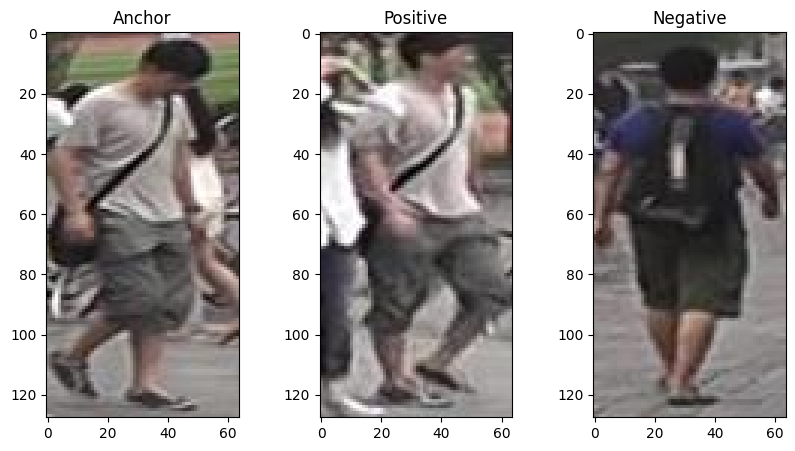

In [ ]:
# Testing train dataset
idx = 42
A, P, N = trainset[idx]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap = "gray")

ax2.set_title("Positive")
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap = "gray")

ax3.set_title("Negative")
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap = "gray")

## Load Dataset into Batches

In [ ]:
# Creating batches of training and testing data
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(testset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in testloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in testloader : 25


In [ ]:
# Testing to see if dataloader works
for A, P, N in trainloader:
  print(f"Anchor image shape : {A.shape}")
  print(f"Positive image shape : {P.shape}")
  print(f"Negative image shape : {N.shape}")

  break

Anchor image shape : torch.Size([32, 3, 128, 64])
Positive image shape : torch.Size([32, 3, 128, 64])
Negative image shape : torch.Size([32, 3, 128, 64])


## Create Model

In [ ]:
class APN_Model(nn.Module):
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                             out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return(embeddings)

In [ ]:
model = APN_Model()
model.to(DEVICE);

## Create Train and Eval Functions

In [ ]:
def train_fn(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             optimizer: torch.optim.Optimizer,
             criterion: torch.nn.Module):
  print(f"Training:-")

  model.to(DEVICE)
  model.train()
  total_loss = 0

  for A, P, N in tqdm(dataloader):
    # Converting from int to float tensors as model weights
    # and biases are such.
    A, P, N = A.type(torch.FloatTensor), P.type(torch.FloatTensor), N.type(torch.FloatTensor)
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # Finding triplet loss
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return(total_loss / len(dataloader))

In [ ]:
def eval_fn(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             criterion: torch.nn.Module):
  print(f"Evaluating:-")

  model.eval()
  with torch.inference_mode():
    total_loss = 0

    for A, P, N in tqdm(dataloader):
      # Converting from int to float tensors as model weights
      # and biases are such.
      A, P, N = A.type(torch.FloatTensor), P.type(torch.FloatTensor), N.type(torch.FloatTensor)
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return(total_loss / len(dataloader))

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LR)

## Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model=model, dataloader = trainloader,
                        optimizer = optimizer, criterion = criterion)
  valid_loss = eval_fn(model = model, dataloader = validloader,
                       criterion = criterion)

  # Saving the best model and valid loss
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("Saved weights successfully")

  print(f"Epochs: {i + 1}, Train loss: {train_loss:.3f}, Valid loss: {valid_loss:.3f}\n")

100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Saved weights successfully
Epochs: 1, Train loss: 0.645, Valid loss: 0.236


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Saved weights successfully
Epochs: 2, Train loss: 0.259, Valid loss: 0.206


100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


Saved weights successfully
Epochs: 3, Train loss: 0.210, Valid loss: 0.159


100%|██████████| 25/25 [00:03<00:00,  7.73it/s]


Saved weights successfully
Epochs: 4, Train loss: 0.118, Valid loss: 0.060


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Saved weights successfully
Epochs: 5, Train loss: 0.067, Valid loss: 0.030


100%|██████████| 25/25 [00:03<00:00,  7.72it/s]


Epochs: 6, Train loss: 0.038, Valid loss: 0.040


100%|██████████| 25/25 [00:03<00:00,  7.83it/s]


Epochs: 7, Train loss: 0.058, Valid loss: 0.042


100%|██████████| 25/25 [00:03<00:00,  7.82it/s]


Epochs: 8, Train loss: 0.061, Valid loss: 0.059


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Epochs: 9, Train loss: 0.084, Valid loss: 0.040


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Epochs: 10, Train loss: 0.083, Valid loss: 0.043


100%|██████████| 25/25 [00:03<00:00,  7.85it/s]


Epochs: 11, Train loss: 0.064, Valid loss: 0.039


100%|██████████| 25/25 [00:03<00:00,  7.89it/s]


Saved weights successfully
Epochs: 12, Train loss: 0.040, Valid loss: 0.028


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Saved weights successfully
Epochs: 13, Train loss: 0.017, Valid loss: 0.004


100%|██████████| 25/25 [00:03<00:00,  7.57it/s]


Epochs: 14, Train loss: 0.030, Valid loss: 0.011


100%|██████████| 25/25 [00:03<00:00,  7.99it/s]

Epochs: 15, Train loss: 0.017, Valid loss: 0.009


## Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.to(DEVICE)
  model.eval()
  with torch.inference_mode():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)

      # Changing from (H, W, C) to (C, H, W) and then scaling
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0

      # Adding an extra dimension (earlier for batches) to input correctly into the model
      A = torch.unsqueeze(A, dim = 0)

      A = A.to(DEVICE)
      A_enc = model(A)

      # squeeze() -> to remove extra dimension
      # cpu() -> to move from gpu to cpu for numpy
      # detach() -> to remove from computaional graph, i.e., to forget change history
      # numpy() -> to convert from tensor to numpy
      encodings.append(A_enc.squeeze(dim = 0).cpu().detach().numpy())

  # Making a dataframe of image names and their encodings
  encodings = pd.DataFrame(encodings)
  df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return(df_enc)

In [ ]:
# Loading the best model which was saved earlier after training
model = APN_Model()
model.load_state_dict(torch.load("best_model.pt"))

df_enc = get_encoding_csv(model = model,
                          anc_img_names = df["Anchor"])

100%|██████████| 4000/4000 [00:50<00:00, 79.94it/s]


In [ ]:
# Saving the encodings in a csv file
df_enc.to_csv("database.csv", index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.122531,-0.111188,-0.016153,0.006312,0.071576,0.084829,0.164268,0.008669,-0.521511,...,0.325130,-0.404123,-0.009321,-0.081659,0.121646,0.327165,-0.179844,0.009901,-0.116104,0.075883
1,1420_c3s3_061978_03.jpg,0.123064,-0.112808,-0.017669,0.005230,0.070773,0.084710,0.164925,0.008234,-0.521779,...,0.325222,-0.402396,-0.008402,-0.080966,0.124609,0.327277,-0.181245,0.011737,-0.117969,0.076341
2,1420_c5s3_062565_05.jpg,0.122973,-0.112656,-0.017013,0.006031,0.070780,0.084525,0.164673,0.007969,-0.521596,...,0.326064,-0.403244,-0.008599,-0.081399,0.123476,0.328026,-0.180703,0.010880,-0.117373,0.076045
3,1420_c6s3_085592_04.jpg,0.122533,-0.111014,-0.016459,0.006046,0.073081,0.085115,0.166730,0.007017,-0.522002,...,0.327468,-0.405027,-0.008921,-0.081255,0.121085,0.329579,-0.179764,0.007689,-0.114972,0.077283
4,0663_c5s3_085987_03.jpg,0.123108,-0.113433,-0.016962,0.005376,0.072012,0.085065,0.166249,0.005001,-0.521458,...,0.327255,-0.402207,-0.007467,-0.082060,0.123183,0.330298,-0.180410,0.009886,-0.117384,0.077422


## Inference

In [ ]:
# Returns the euclidian distance between the given image and every
# anchor image in the dataframe
def euclidian_dist(img_enc, anc_enc_arr):
  distance = np.sqrt(np.dot( (img_enc - anc_enc_arr), (img_enc - anc_enc_arr).T ))
  return(distance)

In [ ]:
# Taking an image and finding its encoding
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

# Reading image
img = io.imread(img_path)

# Converting to tensor, changing dims from (H, W, C) to (C, H, W)
# and scaling
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.inference_mode():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.squeeze(0).detach().cpu().numpy()

In [ ]:
# Storing all anchor image encodings in an array
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
print(f"Shape of anc_enc_arr: {anc_enc_arr.shape}")

# Storing all the anchor image names
anc_img_names = df_enc["Anchor"]
print(f"First few image names:-\n{anc_img_names.head()}")

Shape of anc_enc_arr: (4000, 512)
First few image names:-
0    1420_c5s3_052165_01.jpg
1    1420_c3s3_061978_03.jpg
2    1420_c5s3_062565_05.jpg
3    1420_c6s3_085592_04.jpg
4    0663_c5s3_085987_03.jpg
Name: Anchor, dtype: object


In [ ]:
# Calculating the distance of the reference image encoding with
# every other image encoding
distance = np.array([])     # Creating an empty array

for i in range(anc_enc_arr.shape[0]):
  dist = euclidian_dist(img_enc = img_enc, anc_enc_arr = anc_enc_arr[i, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)
print(f"First 5 closest images are at indices: {closest_idx[:5]}")

First 5 closest images are at indices: [   0 3045 1409 1411 2670]


/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


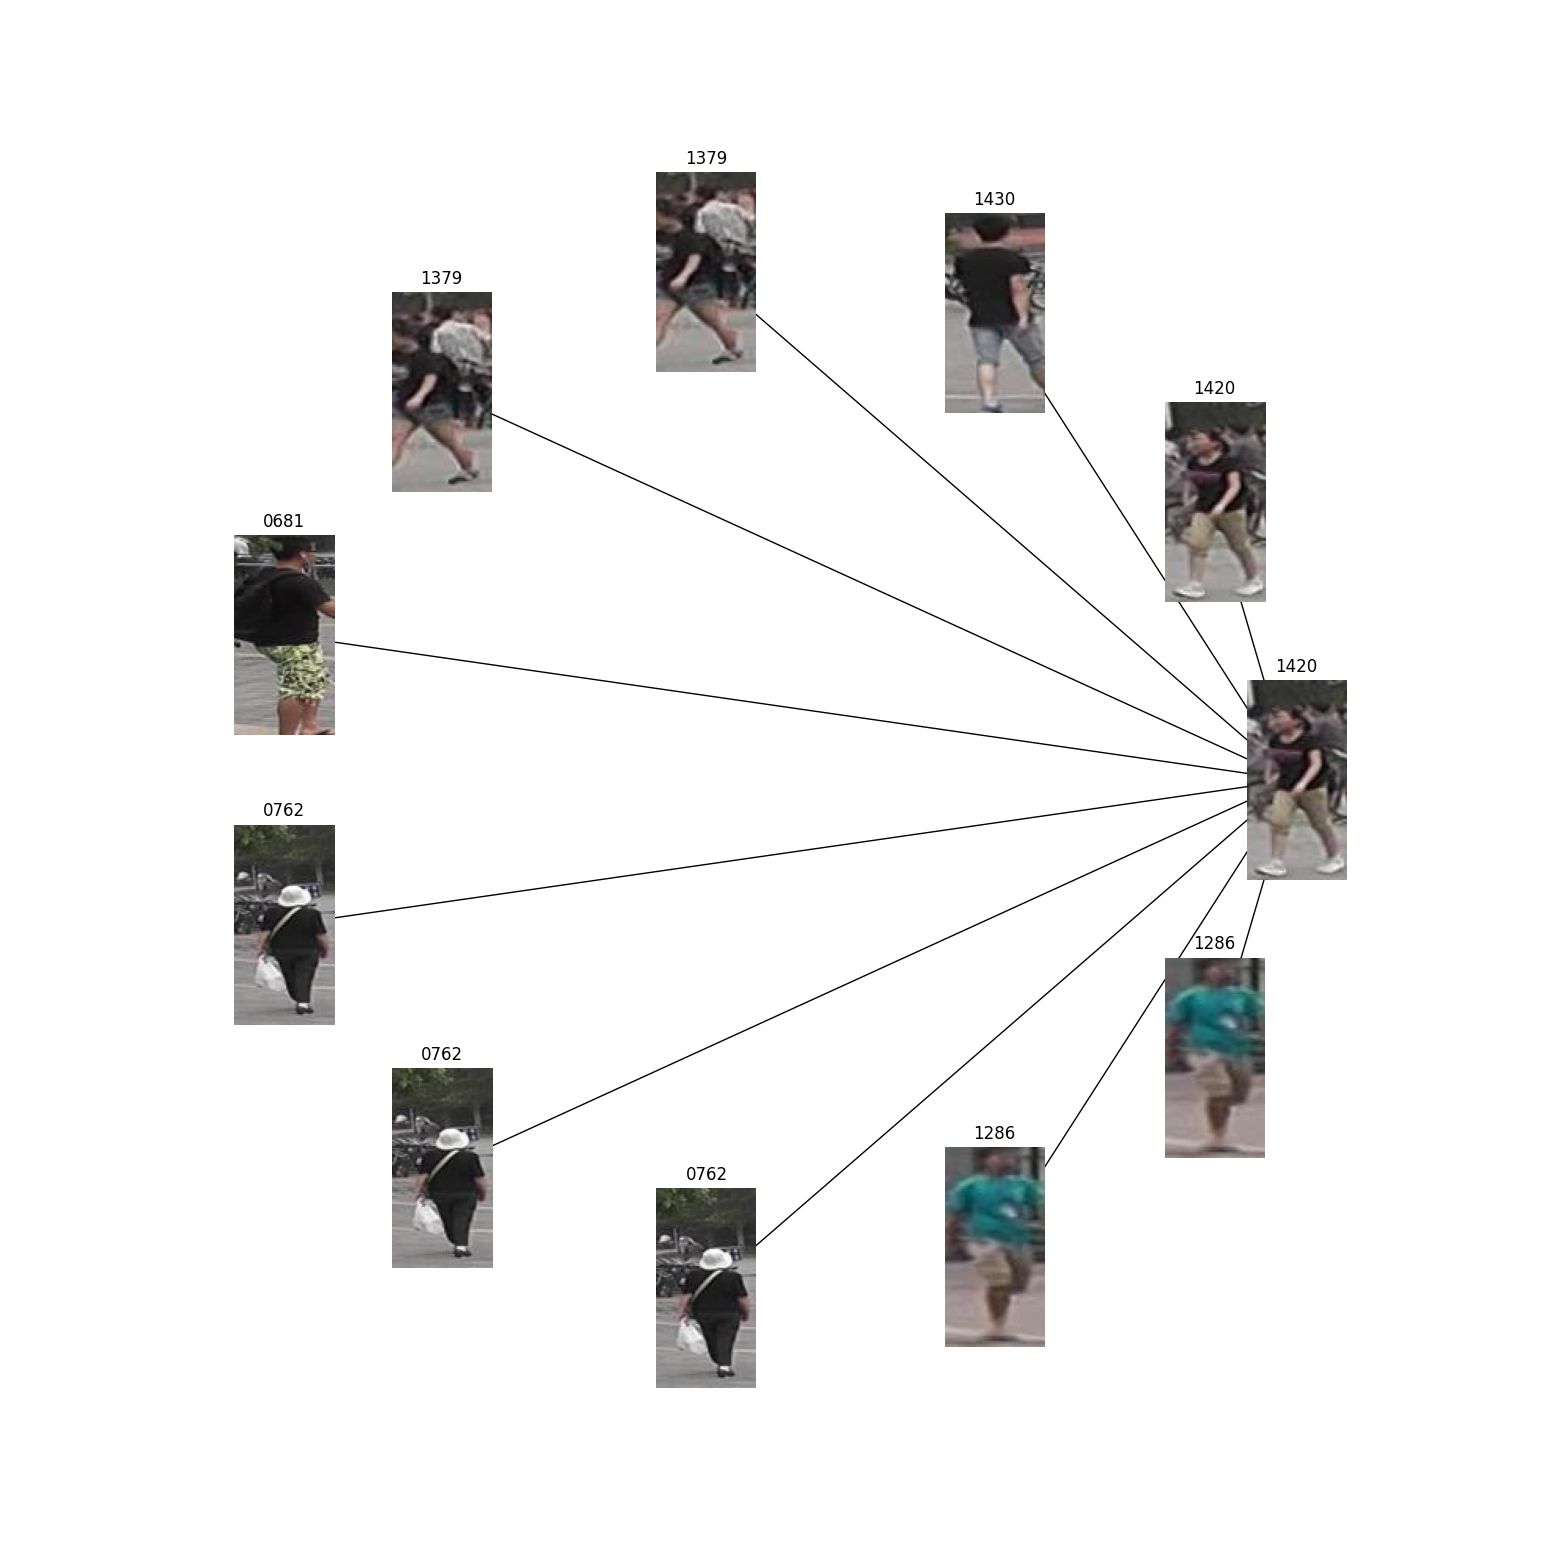

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names = anc_img_names,
                  DATA_DIR = DATA_DIR,
                  image = img,
                  img_path = img_path,
                  closest_idx = closest_idx,
                  distance = distance,
                  no_of_closest = 10)